# Star Schema Data Model

In preparation for visualising the data in `Power BI`, the masterfile is transformed into a star schema data model.

All dimenion tables have a `one-to-many` relationship with the fact table.

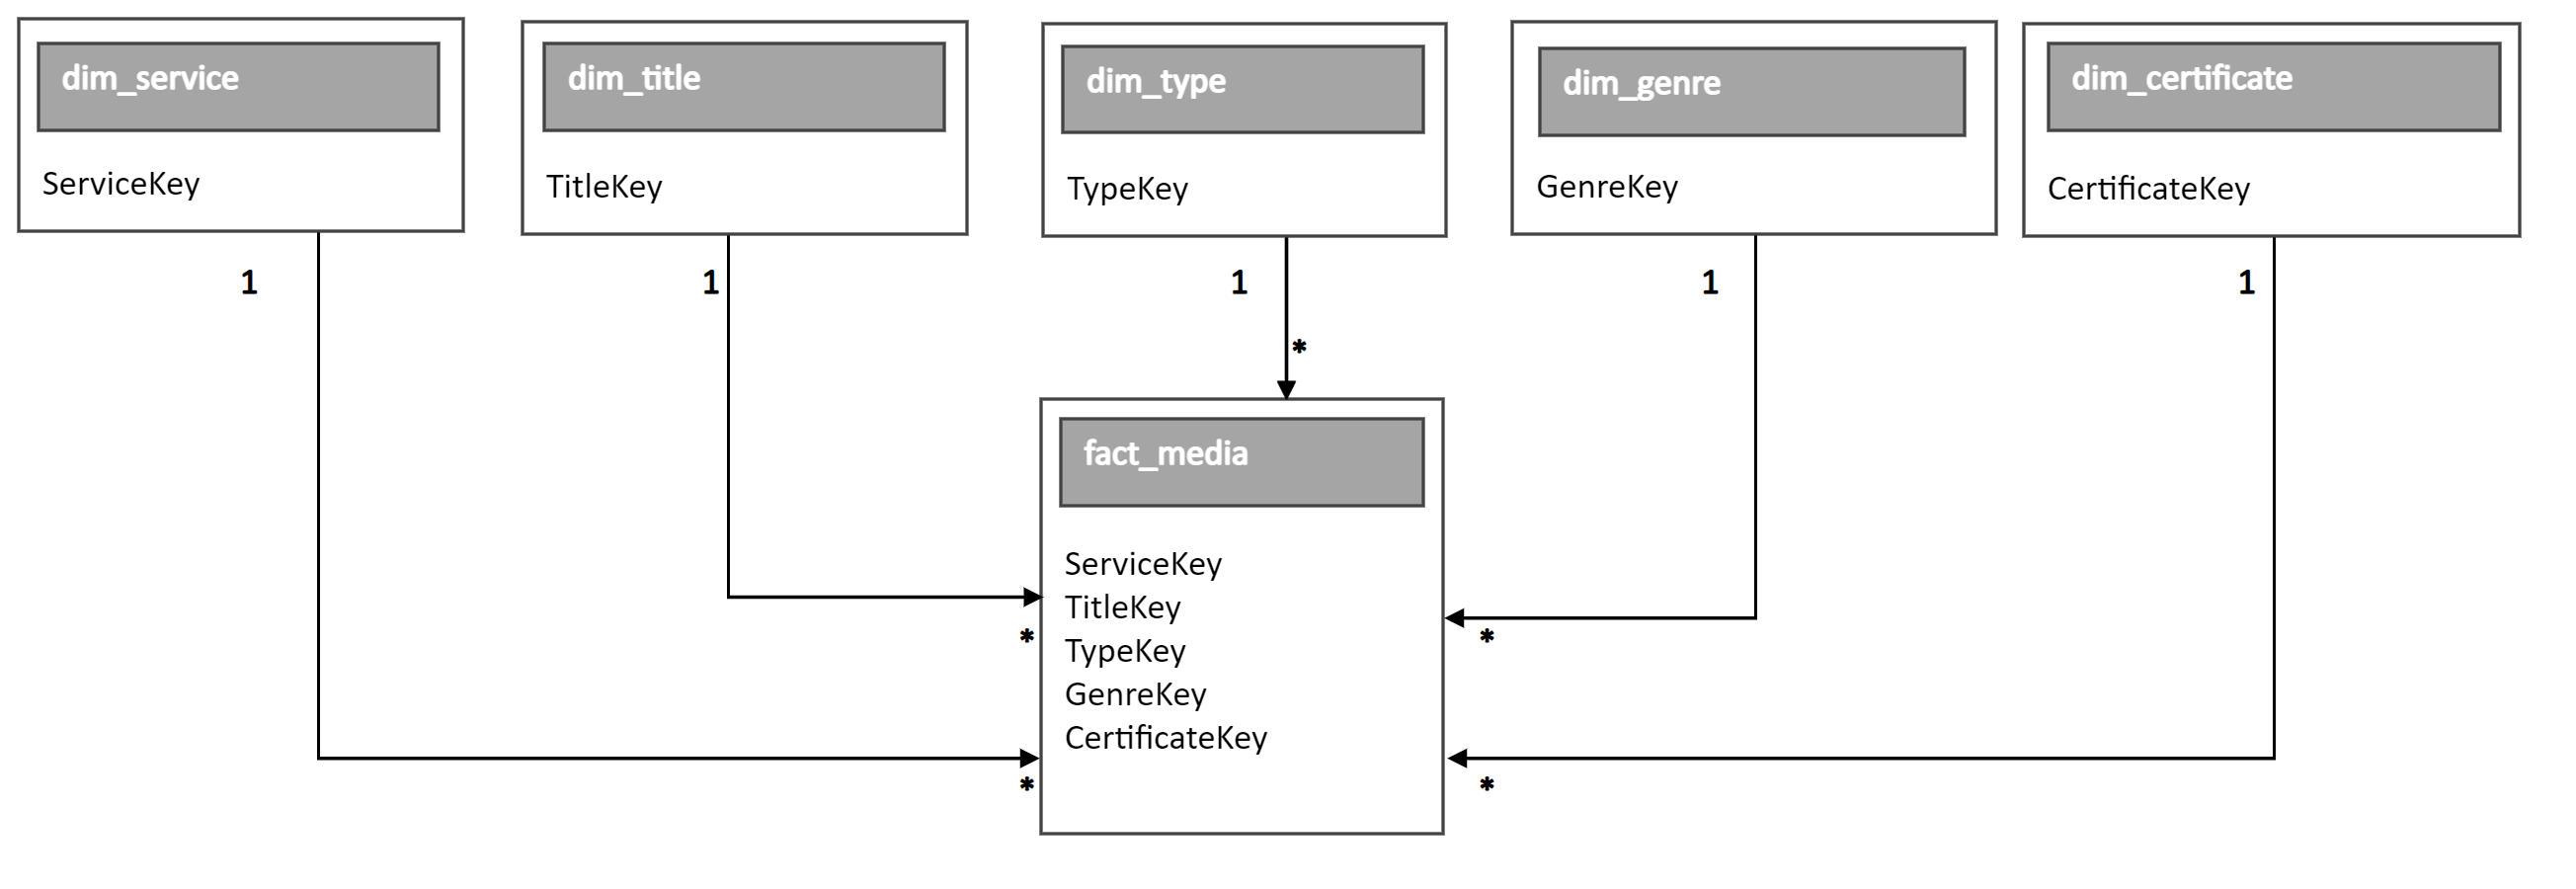

In [1]:
from pathlib import Path
import os
import pandas as pd
import openpyxl as xl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

# Load files

In [2]:
def loadFile(p, extension):
    path = Path(p)
    
    if extension == 'xlsx':
        df = pd.read_excel(path)
    elif extension == 'csv':
        df = pd.read_csv(path, low_memory = False)
    else:
        print('Extension not supported')
    
    return df

First, the clean dataset

In [3]:
filePath = '../Data/Processed/streaming-services-clean-masterfile.csv'
master_df = loadFile(filePath, 'csv') # clean masterfile

Then, the reference files

In [4]:
filePath = '../Data/Staging/table-fields.xlsx' # details which fields are in each dimension / fact table
dfFields = loadFile(filePath, 'xlsx') # For dimension fields retrieval

filePath = '../Data/Staging/table-columns.xlsx' # details the primary key columns
dfColumnKeys = loadFile(filePath, 'xlsx') # For column-key mapping in data model

# Create `dimension` tables

<div class="alert alert-block alert-danger">
    <b>NOTE:</b> <i>fact_media</i> must be done separately
</div>

Retrieve dimension table names

In [5]:
DIM_TABLE_NAMES = list(dfFields[dfFields['Table'] != 'fact_media']['Table'])

### Define functions to help with table creation

#### A function that retrieves all columns for each dimension table

In [6]:
def extractTableCols(fieldsDf, table):
    
    cols = list(fieldsDf[fieldsDf['Table'] == table]['Field'])
    
    return cols

#### A function that creates a sorted dataframe for each table

In [7]:
def createDataFrames(mainDf, fieldsDf, keysDf, tableNames):
    
    dfList = []
    
    for name in tableNames:
        tableCols = extractTableCols(fieldsDf, name)
        keyCol = keysDf[keysDf['Table'] == name]['Key'].iat[0]
        
        df = mainDf[tableCols]
        df = df.drop_duplicates(subset=[keyCol]).sort_values(by=[keyCol], ignore_index=True)
        
        dfList.append(df)
        
    return dfList

#### A function that creates a dimension table with keys

In [8]:
def createDimTables(mainDf, fieldsDf, keysDf, tableNames):
    listDf = createDataFrames(mainDf, fieldsDf, keysDf, tableNames)
    dimTables = []
    index = 0

    for df in listDf:
        colName = tableNames[index]
        keyName = colName.capitalize() + 'Key'

        df = df.reset_index().rename(columns={'index':keyName})

        dimTables.append(df)
        index += 1
    
    return dimTables

And now we build all the `dimension` tables using the above functions!

In [9]:
DIM_TABLES = createDimTables(master_df, dfFields, dfColumnKeys, DIM_TABLE_NAMES)
len(DIM_TABLES)

5

# Create the `fact` table

Retrieve `primary key` columns for each `dimension table`

In [10]:
dimKeyCols = list(dfColumnKeys['Key']) # key columns that must be added onto fact_progress

Retrieve columns for the `fact_media` table

In [11]:
FACT_MEDIA_COLS = list(dfFields[dfFields['Table'] == 'fact_media']['Field']) + dimKeyCols

#### Create `fact_media` 

In [12]:
dfFactMedia = master_df[FACT_MEDIA_COLS]

In [13]:
dfFactMedia.head()

,Release Year,Duration (Mins),Duration (Seasons),Director(s),Cast,Synopsis,Streaming Service,Title,Media Type,Genre(s),Certificate
0,2018,110.0,0,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",A Metro Family decides to fight a Cyber Crimin...,Amazon Prime,Take Care Good Night,Movie,"Drama, International",13+
1,2016,87.0,0,Glenn Miller,"Marcus Anderson, Kaiwi Lyman, Andrew Asper",When a strange virus quickly spreads through a...,Amazon Prime,Zoombies,Movie,"Horror, Science Fiction",13+
2,2008,0.0,1,NaN,Narrator - Gillian Barlett,A heart warming and inspiring series that welc...,Amazon Prime,Zoo Babies,TV Show,"Kids, Special Interest",ALL
3,2020,0.0,1,NaN,Zoë Coombs Marr,Zoë Coombs Marr has been on hiatus. Sort of. F...,Amazon Prime,Zoë Coombs Marr: Bossy Bottom,TV Show,"Comedy, Talk Show and Variety",18+
4,2018,104.0,0,Drake Doremus,"Ewan McGregor, Léa Seydoux, Theo James, Mirand...",ZOE tells a tale of forbidden love between an ...,Amazon Prime,Zoe,Movie,Science Fiction,R


#### Map `primary keys` from all  `dimension` tables to `fact_media`

A function is defined to complete this task

In [14]:
def updateFactColumnsWithKeys(df, tableList, columnList, newColNamesList):
    
    counter = len(tableList)
    index = counter - 1
    
    while counter > 0:
        for dimension in range(len(tableList)):
            df2 = tableList[index].set_index([columnList[index]])
            df2 = df2[~df2.index.duplicated(keep='first')] # remove duplicate indices and keep first occurence
            
            df[columnList[index]] = df[columnList[index]].map(df2[df2.columns[0]]) # maps dim keys to fact table
            
            newColName = newColNamesList[index].capitalize() + 'Key'
            colNameUpdate = {columnList[index]:newColName}
            df.rename(columns=colNameUpdate, inplace = True) # renames key columns in fact table to dimension table names
            
            counter -= 1
            index -= 1
            
    return df

Let's now map the keys...

In [15]:
dfFactMedia = updateFactColumnsWithKeys(dfFactMedia, DIM_TABLES, dimKeyCols, DIM_TABLE_NAMES)
dfFactMedia.head()

,Release Year,Duration (Mins),Duration (Seasons),Director(s),Cast,Synopsis,ServiceKey,TitleKey,TypeKey,GenreKey,CertificateKey
0,2018,110.0,0,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",A Metro Family decides to fight a Cyber Crimin...,0,14652,0,960,0
1,2016,87.0,0,Glenn Miller,"Marcus Anderson, Kaiwi Lyman, Andrew Asper",When a strange virus quickly spreads through a...,0,19078,0,1100,0
2,2008,0.0,1,NaN,Narrator - Gillian Barlett,A heart warming and inspiring series that welc...,0,19076,1,1202,7
3,2020,0.0,1,NaN,Zoë Coombs Marr,Zoë Coombs Marr has been on hiatus. Sort of. F...,0,19083,1,762,3
4,2018,104.0,0,Drake Doremus,"Ewan McGregor, Léa Seydoux, Theo James, Mirand...",ZOE tells a tale of forbidden love between an ...,0,19061,0,1256,14


# Prep Tables for Excel dump

Add `fact_media` to `dimensions` list

In [16]:
DIM_TABLES.append(dfFactMedia)
len(DIM_TABLES)

6

Create list of worksheet names for all tables

In [17]:
sheet = []

for name in DIM_TABLE_NAMES:
    sheetName = 'dim_' + name
    sheet.append(sheetName)

sheet.append('fact_media')
sheet

['dim_service',
 'dim_title',
 'dim_type',
 'dim_genre',
 'dim_certificate',
 'fact_media']

# Save Data Model to Processed folder

In [18]:
filePath = '../Data/Processed/streaming-services-data-model.xlsx'
path = Path(filePath)
writer = pd.ExcelWriter(path)

for df, n in zip(DIM_TABLES, sheet):
    df.to_excel(writer, index=False, sheet_name=n)
    
writer.save()